In [12]:
# Se cargan las librerías
library("dplyr")
library("readr")
library("ggplot2")
# Paquete que contiene la función sample.split
library("caTools")
# Paquete que contiene la función para el modelo de análisis discriminante
library("MASS")
# Paquete que contiene la función para el modelo de k-vecinos
library(class)
# Paquete que contiene la función para las gráficas ROC
library("ROCR")


In [13]:
# Lee la información de los archivos
usuarios <- read.table("./movies_data/u.user", header = TRUE, sep = "|")
peliculas <- read.table("./movies_data/u.item", header = TRUE, sep = "|")
calificaciones <- read.table("./movies_data/udata.data", header = TRUE, sep = "\t")


In [14]:
# Se crea una tabla con la información de los usuarios y sus calificaciones
info <- left_join(usuarios, calificaciones, by = "userid", multiple = "all")
info <- left_join(info, peliculas, by = "itemid")


In [15]:
# Se crea una función para calcular el porcentaje de aciertos
precision <- function(x) {
    sum(diag(x) / (sum(rowSums(x)))) * 100
}


In [16]:
head(info)


,userid,age,gender,occupation,zcode,itemid,rate,timestamp,title,rdate,⋯,Fantasy,FilmNoir,Horror,Musical,Mystery,Romance,SciFi,Thriller,War,Western
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,24,M,technician,85711,61,4,878542420,Three Colors: White (1994),01-Jan-1994,⋯,0,0,0,0,0,0,0,0,0,0
2,1,24,M,technician,85711,189,3,888732928,"Grand Day Out, A (1992)",01-Jan-1992,⋯,0,0,0,0,0,0,0,0,0,0
3,1,24,M,technician,85711,33,4,878542699,Desperado (1995),01-Jan-1995,⋯,0,0,0,0,0,1,0,1,0,0
4,1,24,M,technician,85711,160,4,875072547,Glengarry Glen Ross (1992),01-Jan-1992,⋯,0,0,0,0,0,0,0,0,0,0
5,1,24,M,technician,85711,20,4,887431883,Angels and Insects (1995),01-Jan-1995,⋯,0,0,0,0,0,1,0,0,0,0
6,1,24,M,technician,85711,202,5,875072442,Groundhog Day (1993),01-Jan-1993,⋯,0,0,0,0,0,1,0,0,0,0


In [17]:
colnames(info)


[1] "userid"      "age"         "gender"      "occupation"  "zcode"      
 [6] "itemid"      "rate"        "timestamp"   "title"       "rdate"      
[11] "vrdate"      "IMDbURL"     "unknown"     "Action"      "Adventure"  
[16] "Animation"   "Children"    "Comedy"      "Crime"       "Documentary"
[21] "Drama"       "Fantasy"     "FilmNoir"    "Horror"      "Musical"    
[26] "Mystery"     "Romance"     "SciFi"       "Thriller"    "War"        
[31] "Western"

In [18]:
# Planteamiento para modelo de regresión logística
# ¿Cómo puedo saber si una calificación fue hecha por un hombre o una mujer?

# Se agrega una columna con el género del usuario en forma de bit, 1 para mujer y 0 para hombre,
# esto con el fin de poder utilizarlo en el modelo de regresión logística
info$gender_as_bit <- ifelse(info$gender == "F", 1, 0)


In [19]:
# Se separan los datos en entrenamiento y prueba
separador_RL <- sample.split(info, SplitRatio = 0.8)
info_entrenamiento_RL <- info[separador_RL, ]
info_prueba_RL <- info[-separador_RL, ]


In [20]:
# Se crea el modelo de regresión logística

modelo_RL <- glm(gender_as_bit ~ itemid + rate + unknown + Action + Adventure + Animation + Children + Comedy + Crime + Documentary + Drama + Fantasy + FilmNoir + Horror + Musical + Mystery + Romance + SciFi + Thriller + War + Western,
    data = info_entrenamiento_RL,
    family = binomial
)


In [21]:
# Se obtienen 3 registros de prueba, sin la columna de género
reg_prueba_RL <- info_prueba_RL[1:3, -info_prueba_RL$gender_as_bit]
# Se obtienen las probabilidades de que el usuario sea hombre o mujer (la predicción)
prediccion_RL <- predict(modelo_RL, reg_prueba_RL, type = "response")


In [22]:
# Se obtiene la predicción final
prediccion_RL <- ifelse(prediccion_RL > 0.5, "F", "M")
reg_prueba_RL
prediccion_RL


,age,gender,occupation,zcode,itemid,rate,timestamp,title,rdate,vrdate,⋯,FilmNoir,Horror,Musical,Mystery,Romance,SciFi,Thriller,War,Western,gender_as_bit
,<int>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<lgl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
2,24,M,technician,85711,189,3,888732928,"Grand Day Out, A (1992)",01-Jan-1992,NA,⋯,0,0,0,0,0,0,0,0,0,0
3,24,M,technician,85711,33,4,878542699,Desperado (1995),01-Jan-1995,NA,⋯,0,0,0,0,1,0,1,0,0,0
4,24,M,technician,85711,160,4,875072547,Glengarry Glen Ross (1992),01-Jan-1992,NA,⋯,0,0,0,0,0,0,0,0,0,0


2   3   4 
"M" "M" "M"

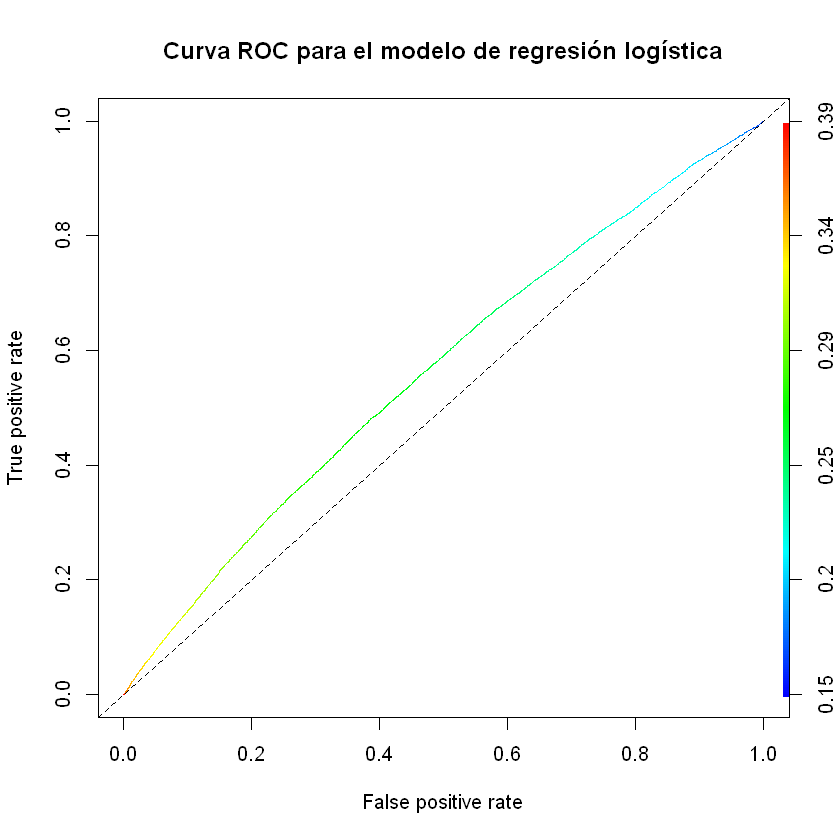

In [23]:
# Se hace una predicción para todos los registros de prueba
prediccion_RL <- predict(modelo_RL, info_prueba_RL, type = "response")
# Se usa la gráfica ROC para evaluar el modelo
prediccion_RL <- prediction(prediccion_RL, info_prueba_RL$gender_as_bit)
perf_RL <- performance(prediccion_RL, measure = "tpr", x.measure = "fpr")
plot(perf_RL, colorize = TRUE, main = "Curva ROC para el modelo de regresión logística")
abline(0, 1, lty = 2)


A través de esta gráfica, se puede apreciar que el rendimiento de modelo es pobre, pues al probar con múltiples umbrales (thresholds) se nota como el modelo incrementa tu tasa de verdaderos positivos (cuando predice que la calificación fue dada por un usuario mujer y está en lo correcto), pero también su tasa de falsos positivos (se equivoca al decir que una calificación fue hecha por una mujer, cuando no fue así)

De esto se puede terminar que, a partir de la complejidad de los datos, determinar si la calificación fue hecha por un hombre o una mujer no es una tarea factible.

In [13]:
# Planteamiento para modelo de análisis discriminante
# Se desea saber el grupo etario de un usuario a partir de su ocupación, calificaciones,
# género de las películas (se seleccionan 5) y sexo

# Revisamos la edad máxima y mínima de los usuarios
max(info$age)
min(info$age)


[1] 73

[1] 7

In [14]:
# Se crea una columna con el grupo etario del usuario, "ñ" para niños, "a" para adolescentes, "A" para adultos y "AM" para adultos mayores
info$age_group <- ifelse(info$age < 10, "ñ",
    ifelse(info$age < 18, "a",
        ifelse(info$age < 60, "A", "AM")
    )
)


In [15]:
info_p_AD <- info
# Se aplica la función scale() para asegurar los prerrequisitos del modelo (media 0 y desviación estándar 1)
# Se aplica para las columnas numéricas
info_p_AD[, sapply(info_p_AD, is.numeric)] <- scale(info[, sapply(info, is.numeric)])


In [16]:
# A cada ocupación diferente se le asigna un número
info_p_AD$occupation_as_n <- as.numeric(factor(info_p_AD$occupation))
info_p_AD$occupation_as_n <- scale(info_p_AD$occupation_as_n)


In [17]:
# Se verifica
apply(info_p_AD[, sapply(info_p_AD, is.numeric)], 2, mean)
apply(info_p_AD[, sapply(info_p_AD, is.numeric)], 2, sd)


userid             age          itemid            rate       timestamp 
  -3.278708e-17   -1.175033e-16    4.183498e-17   -1.970095e-16   -8.015971e-15 
        unknown          Action       Adventure       Animation        Children 
   4.554447e-18    1.199822e-17   -3.688812e-17    2.448493e-17    2.282386e-17 
         Comedy           Crime     Documentary           Drama         Fantasy 
   6.625731e-17    1.768509e-17   -1.417697e-18   -2.541236e-17   -4.540952e-19 
       FilmNoir          Horror         Musical         Mystery         Romance 
  -4.974758e-18    1.200709e-17   -1.308128e-17    3.409044e-17   -2.120640e-17 
          SciFi        Thriller             War         Western   gender_as_bit 
   5.002285e-18    1.483513e-17    1.589902e-17   -2.135157e-17   -9.737158e-17 
occupation_as_n 
   3.120095e-19

userid             age          itemid            rate       timestamp 
              1               1               1               1               1 
        unknown          Action       Adventure       Animation        Children 
              1               1               1               1               1 
         Comedy           Crime     Documentary           Drama         Fantasy 
              1               1               1               1               1 
       FilmNoir          Horror         Musical         Mystery         Romance 
              1               1               1               1               1 
          SciFi        Thriller             War         Western   gender_as_bit 
              1               1               1               1               1 
occupation_as_n 
              1

In [18]:
# Se separan las muestras en entrenamiento y prueba
separador_AD <- sample(1:nrow(info_p_AD), 0.8 * nrow(info_p_AD))
info_entrenamiento_AD <- info_p_AD[separador_AD, ]
info_prueba_AD <- info_p_AD[-separador_AD, ]


In [19]:
# Se crea el modelo de análisis discriminante, seleccionando 5 géneros de películas como referencia
modelo_AD <- lda(age_group ~ rate + occupation_as_n + gender_as_bit + Action + Children + Crime + Romance + SciFi,
    data = info_entrenamiento_AD
)


In [20]:
# Se obtienen 3 registros de prueba, sin la columna de grupo etario
reg_prueba_AD <- info_prueba_AD[1:3, ]
# Se obtienen las probabilidades de que el usuario pertenezca a cada grupo etario (la predicción)
prediccion_AD <- predict(modelo_AD, reg_prueba_AD)


In [21]:
reg_prueba_AD
prediccion_AD


,userid,age,gender,occupation,zcode,itemid,rate,timestamp,title,rdate,⋯,Musical,Mystery,Romance,SciFi,Thriller,War,Western,gender_as_bit,age_group,occupation_as_n
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,"<dbl[,1]>"
1,-1.730907,-0.7757625,M,technician,85711,-1.1019708,0.4176522,-0.9331148,Three Colors: White (1994),01-Jan-1994,⋯,-0.2283016,-0.2352716,-0.4915609,-0.3819263,-0.5291012,-0.3220673,-0.137441,-0.5887415,A,1.196413
12,-1.730907,-0.7757625,M,technician,85711,-0.6152695,0.4176522,-0.8711805,Star Trek: First Contact (1996),22-Nov-1996,⋯,-0.2283016,-0.2352716,-0.4915609,2.6182802,-0.5291012,-0.3220673,-0.137441,-0.5887415,A,1.196413
13,-1.730907,-0.7757625,M,technician,85711,-0.5215568,1.3060091,-1.6023787,"Pillow Book, The (1995)",13-Jun-1997,⋯,-0.2283016,-0.2352716,2.0343158,-0.3819263,-0.5291012,-0.3220673,-0.137441,-0.5887415,A,1.196413


$class
[1] A A A
Levels: a A AM ñ

$posterior
            a         A         AM            ñ
1  0.03927417 0.9175351 0.04252513 0.0006656147
12 0.04562316 0.9331500 0.01907439 0.0021524867
13 0.03610820 0.9117856 0.05023596 0.0018702482

$x
          LD1         LD2        LD3
1  -0.8632885  1.18641852 -0.5662896
12 -1.1508896 -0.07824143  1.9442907
13 -0.7777013  1.48606838  0.7510413

In [22]:
prediccion_AD <- predict(modelo_AD, info_prueba_AD)$x


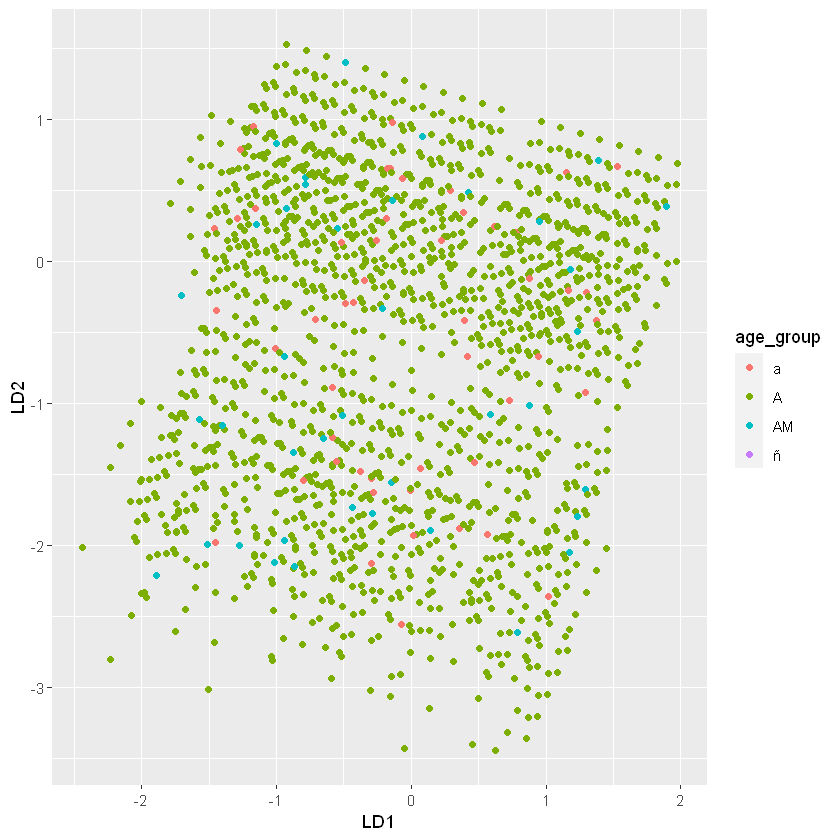

In [23]:
plot_AD <- cbind(info_entrenamiento_AD, prediccion_AD)
# Realizamos una predicción para todos los datos de prueba y observamos la separación de los grupos
ggplot(plot_AD, aes(LD1, LD2)) +
  geom_point(aes(color = age_group))


A través de este gráfico se puede concluir que, tal como se mecionaba con anterioridad, los datos son bastante heterogeneos, por lo que realizar una separación de los grupos etarios presenta un desafío para el modelo de análisis discriminante, debido a que muchos usuarios de diferentes edades comparten gustos de cine.

Para realizar esta separación con mayor éxito, debe existir una descripción más exhaustiva del usuario que califica la película, así como posiblemente emplear más columnas de género para aumentar la precisión del modelo de AD.

In [24]:
# Planteamiento para modelo k-vecinos
# Se desea saber la ocupación de un usuario a partir de su edad y calificaciones

# Se recuperarán únicamentélas columnas de edad, calificaciones y ocupación, ya que
# el algoritmo de k-vecinos, en primera instancia, sólo trabaja con datos numéricos.
info_p_KV <- info[, c("age", "rate", "occupation")]
head(info_p_KV)


,age,rate,occupation
,<int>,<int>,<chr>
1,24,4,technician
2,24,3,technician
3,24,4,technician
4,24,4,technician
5,24,4,technician
6,24,5,technician


In [25]:
info_p_KV <- unique(info_p_KV)


In [26]:
nrow(info_p_KV)


[1] 2067

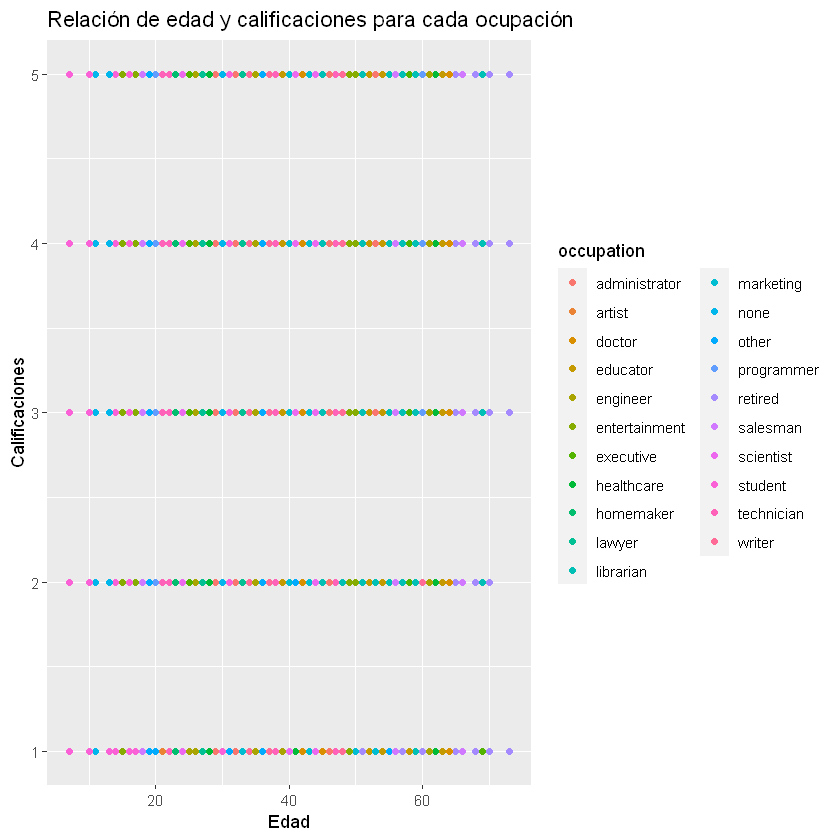

In [27]:
ggplot(info_p_KV, aes(x = age, y = rate, color = occupation)) +
    geom_point() +
    labs(title = "Relación de edad y calificaciones para cada ocupación", x = "Edad", y = "Calificaciones")


Con ayuda de este gráfico se puede visualizar cómo las ocupaciones de distribuyen de manera similar en el eje vertical (indicando que, posiblemente, las calificaciones de un usuario están poco relacionadas con su ocupación), pero presentan una vasta heterogeneidad en el eje horizontal. Podemos ver cómo múltiples colores (ocupaciones) se aglomeran en ciertos rangos etarios, por lo que se espera que esta variable sea de gran injerencia al realizar una predicción.

In [28]:
# Se declara la función para normalizar los datos, que permite deshacerse de diferencias
# de magnitud entre los datos y nos permite graficarlos en un mismo plano.
normalizar <-
    function(x) {
        (x - min(x)) / (max(x) - min(x))
    }


In [29]:
info_p_KV_norm <- as.data.frame(lapply(info_p_KV[, c("age", "rate")], normalizar))
head(info_p_KV_norm)


,age,rate
,<dbl>,<dbl>
1,0.2575758,0.75
2,0.2575758,0.50
3,0.2575758,1.00
4,0.2575758,0.25
5,0.2575758,0.00
6,0.6969697,0.75


In [30]:
# Separación de los datos en entrenamiento y prueba
separador_KV <- sample(1:nrow(info_p_KV_norm), 0.8 * nrow(info_p_KV_norm))
info_entrenamiento_KV <- info_p_KV_norm[separador_KV, ]
info_prueba_KV <- info_p_KV_norm[-separador_KV, ]


In [31]:
# Se crea el modelo de k-vecinos
predicciones <- knn(info_entrenamiento_KV, # Datos de entrenamiento
    info_prueba_KV, # Datos de prueba
    info_p_KV[separador_KV, 3], # Etiquetas bajo las cuales se clasificarán los datos de entrenamiento
    k = 7
) # Número de vecinos


In [32]:
# Se crea una matriz de confusión para ver la precisión del algoritmo
tab <- table(predicciones, info_p_KV[-separador_KV, 3])
tab


               
predicciones    administrator artist doctor educator engineer entertainment
  administrator             0      3      0        1        3             0
  artist                    2      0      1        1        0             0
  doctor                    0      0      0        0        1             0
  educator                  3      4      0        0        7             2
  engineer                  4      2      0        3        1             1
  entertainment             0      0      0        0        0             0
  executive                 4      0      0        4        0             1
  healthcare                0      0      0        0        0             0
  homemaker                 0      0      0        0        0             1
  lawyer                    2      0      1        0        2             1
  librarian                 2      2      0        3        2             1
  marketing                 1      1      0        0        1           

In [33]:
# En esta función se divide el número de predicciones correctas entre el número total de predicciones, lo que nos dice
# qué tan preciso es el modelo.
precision(tab)


[1] 1.207729

Nuevamente, la diversidad de la información (y posiblemente la falta de esta) empobrecen el rendimiento de nuestro modelo, pues al igual que otras variables de clasificación (a excepción del género de la película), dicen poco de cómo un usuario se comporta al calificar.

Finalmente, sería importante revisar la vigencia de estos datos, y/o enriquecer los planteamientos con más detalles, pues a partir de pocas variables es difícil ser certero en las predicciones.